In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

# accessing data library
from statsbombpy import sb

# opening the libraries as DF's
from mplsoccer import Sbopen
parser = Sbopen()

# plotting
import os
import pathlib
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Capturing the teams competing each season

In [395]:
ssn1819 = pd.read_csv('../data/matches_ssn1819.csv')

In [169]:
## 2018/19 Teams

ssn1819_teams = ssn1819['team'].unique().tolist()
ssn1819_teams

['Manchester City WFC',
 'Chelsea FCW',
 'Brighton & Hove Albion WFC',
 'Bristol City WFC',
 'Reading WFC',
 'Yeovil Town LFC',
 'Arsenal WFC',
 'Liverpool WFC',
 'Birmingham City WFC',
 'Everton LFC',
 'West Ham United LFC']

In [170]:
## 2019/20 Teams

ssn1920 = pd.read_csv('../data/matches_ssn1920.csv')
ssn1920_teams = ssn1920['team'].unique().tolist()
ssn1920_teams

['Bristol City WFC',
 'Brighton & Hove Albion WFC',
 'Manchester City WFC',
 'Manchester United',
 'Chelsea FCW',
 'Tottenham Hotspur Women',
 'Liverpool WFC',
 'Reading WFC',
 'Birmingham City WFC',
 'Everton LFC',
 'Arsenal WFC',
 'West Ham United LFC']

In [171]:
## 2020/21 Teams

ssn2021 = pd.read_csv('../data/matches_ssn2021.csv')
ssn2021_teams = ssn2021['team'].unique().tolist()
ssn2021_teams

['Aston Villa',
 'Manchester City WFC',
 'Arsenal WFC',
 'Reading WFC',
 'Tottenham Hotspur Women',
 'West Ham United LFC',
 'Brighton & Hove Albion WFC',
 'Birmingham City WFC',
 'Bristol City WFC',
 'Everton LFC',
 'Manchester United',
 'Chelsea FCW']

# Defining what will be considered a 'short pass' from a Goal Kick 

## <ins>The Variables<ins>


+ ### SHORT Goal Kick < 25.1 (x)
+ ### LONG Goal Kick > 25.1 (x)
+ ### LEFT GOAL KICK =< 38 (y)
+ ### CENTRE GOAL KICK  <= 42.9 & >= 38.1 (y)
+ ### RIGHT GOAL KICK => 43 (y)
    
## <ins>Progressive Pass<ins>
+ End location of the pass is 25% closer to the goal than the starting point
+ only successful passes

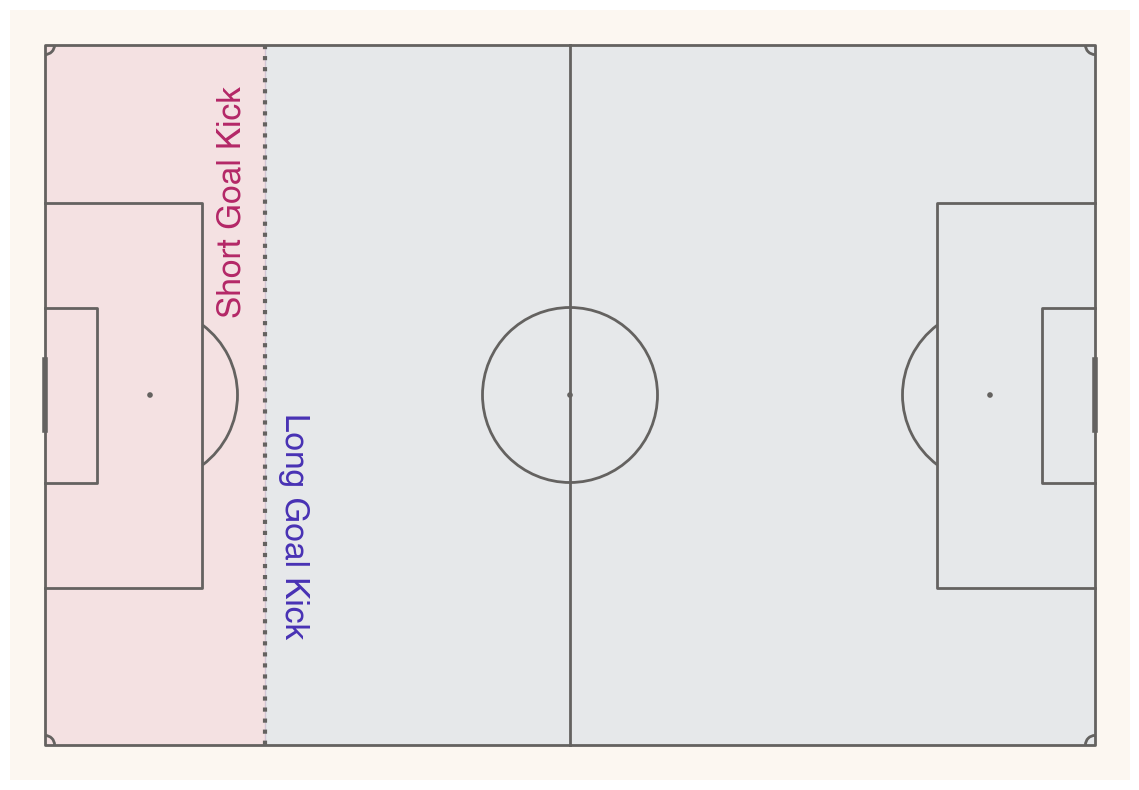

In [403]:

# Create a soccer pitch
pitch = Pitch(pitch_color='#fcf7f1', line_color='#646260', stripe=False, stripe_color='#a8cf8d',
              linestyle='-', corner_arcs = True, positional=False, line_zorder=2)

# Create a Matplotlib figure
fig, ax = pitch.draw(figsize=[12, 8])

# Shade the 'short pass' area in red / 'long pass' area in blue...
ax.fill_between([0, 25.1], 0, 80, color='#b42767', alpha=0.1)
ax.fill_between([25.2, 120], 0, 80, color='#2767b4', alpha=0.1)

# Adding the short/long pass dividing line
ax.vlines(x=25.2, ymin=0, ymax=80, color='#646260', linestyle='dotted', linewidth=3)

# Adding the short/long pass labeling
plt.text(x=23.2, y=18, s='Short Goal Kick', color='#b42767',rotation = 90,
         ha='right', va='center', fontsize=24, weight='bold',family='Helvetica')

plt.text(x=26.6, y=55, s='Long Goal Kick', color='#4831b4',rotation = 270,
         ha='left', va='center', fontsize=24, weight='extra bold',family='Helvetica')

# Plot Title
#ax.set_title('Defining Goal Kick Variables', color='#646260', fontsize=38,family='Helvetica')

# Display the plot
plt.show()

## Now that I have the match events concatenated into individual seasons, I want to explore the avg. progression for each team from a GK. I will need to:

+ Only consider the 'types' _Shot, Carry, Shot, Goal Keeper_ as these are the only types w/ end locations.
+ Groupby matches and extract the 'play_pattern' _From Goalkick_ possession chains for each match.
+ Groupby team ('possession_team') and possession chain ('possession').


+ ### Some important notes RE: the data...
    + all contain 88 columns, now reduced to 27
    + Season 2018/19 contained 360,362 rows
    + Season 2019/20 contained 292,255 rows
    + Season 2020/21 contained 443,304 rows

In [382]:
start_set = {'team': [],
            'season' : [],
            'total_GKs' : [],#
            'short_GKs' : [],#
            'long_GKs' : [],#
            'GKs_distnce_std' : [],#
            'shortGK_avg_xkick_lft' : [],#
            'shortGK_avg_ykick_lft' : [],# 
            'shortGK_avg_xkick_cntr' : [],#
            'shortGK_avg_ykick_cntr' : [],#
            'shortGK_avg_xkick_rght' : [],#
            'shortGK_avg_ykick_rght' : [],#
            'short_avg_num_passes' : [],#
            'short_avg_num_prog_passes' : [],
            'short_avg_num_prog_carries' : [],
            'long_avg_num_passes' : [],#
            'long_avg_num_prog_passes' : [],
            'long_avg_num_prog_carries' : [],
            'short_end_shot' : [],#
            'short_end_goal' : [],#
            'short_avg_xg' : [],#
            'long_end_shot' : [],#
            'long_end_goal' : [],#
            'long_avg_xg' : [],#
            'short_avg_x_prog' : [],#
            'fllw_shrt_x_rtrn' : [],#
            'fllw_shrt_shots_rtrn' : [],#
            'fllw_shrt_goals_rtrn' : [],#
            'fllw_shrt_avg_xg_rtrn' : [],#
            #'fllw_min_shrt_shots_for' : [],
            #'fllw_min_shrt_shots_agnst' : [], 
            'long_avg_x_prog' : [],#
            'fllw_long_x_rtrn' : [],#
            'fllw_long_shots_rtrn' : [],#
            'fllw_long_goals_rtrn' : [],#
            'fllw_long_avg_xg_rtrn' : []#
            #,'fllw_min_long_shots_for' : [],
            #'fllw_min_long_shots_agnst' : []
            }

In [383]:
full_set = pd.DataFrame(start_set)

full_set

,team,season,total_GKs,short_GKs,long_GKs,GKs_distnce_std,shortGK_avg_xkick_lft,shortGK_avg_ykick_lft,shortGK_avg_xkick_cntr,shortGK_avg_ykick_cntr,...,short_avg_x_prog,fllw_shrt_x_rtrn,fllw_shrt_shots_rtrn,fllw_shrt_goals_rtrn,fllw_shrt_avg_xg_rtrn,long_avg_x_prog,fllw_long_x_rtrn,fllw_long_shots_rtrn,fllw_long_goals_rtrn,fllw_long_avg_xg_rtrn


## <ins> Only consider the 'types' Shot, Carry, Shot, Goal Keeper as these are the only types w/ end locations. <ins>

In [396]:
ssn1819 = ssn1819.loc[(ssn1819["type"] == "Pass") | 
                      (ssn1819["type"] == "Carry") | 
                      (ssn1819["type"] == 'Shot') | 
                      (ssn1819["type"] == 'Goal Keeper') |
                      (ssn1819["type"] == 'Starting XI') |
                      (ssn1819["type"] == 'Half Start') |
                      (ssn1819["type"] == 'Injury Stoppage') |
                      (ssn1819['type'] == 'Half End')]

In [397]:
ssn1819['timestamp'] = pd.to_datetime(ssn1819['timestamp'])

ssn1819[['timestamp']].head(20)

,timestamp
0,2023-11-01 00:00:00.000
1,2023-11-01 00:00:00.000
2,2023-11-01 00:00:00.000
3,2023-11-01 00:00:00.000
4,2023-11-01 00:00:00.000
5,2023-11-01 00:00:00.000
6,2023-11-01 00:00:00.100
7,2023-11-01 00:00:00.500
8,2023-11-01 00:00:25.873
9,2023-11-01 00:00:28.460


In [ ]:
df['TimeColumn'] = df['DateTimeColumn'].dt.time

In [398]:
# CONVERTING TIMESTAMP TO MINUTE, SECOND, MILLISECOND COLUMNS

ssn1819['minute'] = ssn1819['timestamp'].apply(lambda row: row.minute)
ssn1819['second'] = ssn1819['timestamp'].apply(lambda row: row.second)
ssn1819['millisecond'] = ssn1819['timestamp'].apply(lambda row: row.microsecond // 1000) 

ssn1819.sort_values(by=['match','minute',
                        'second','millisecond',
                        'possession']).reset_index(drop=True)[['match','timestamp', 
                                                               'minute', 'second', 'millisecond']].head(20)

,match,timestamp,minute,second,millisecond
0,7298,2023-11-01 00:00:00.000,0,0,0
1,7298,2023-11-01 00:00:00.000,0,0,0
2,7298,2023-11-01 00:00:00.000,0,0,0
3,7298,2023-11-01 00:00:00.000,0,0,0
4,7298,2023-11-01 00:00:00.000,0,0,0
5,7298,2023-11-01 00:00:00.000,0,0,0
6,7298,2023-11-01 00:00:00.001,0,0,1
7,7298,2023-11-01 00:00:00.100,0,0,100
8,7298,2023-11-01 00:00:00.100,0,0,100
9,7298,2023-11-01 00:00:00.494,0,0,494


In [164]:
# REFINING / RE-ORDERING THE COLUMNS

ssn1819 = ssn1819[['match','home_team','away_team','minute','second','millisecond',
                   'duration','possession','possession_team','defending_team',
                   'play_pattern','type','team','player','position',
                   'pass_length','pass_angle','pass_height','pass_outcome','pass_body_part','pass_shot_assist',
                   'shot_statsbomb_xg','shot_outcome',
                   'x_start', 'y_start','x_end','y_end','z_end_shot']]

In [167]:
# ARRAGNING THE DATA

ssn1819 = ssn1819.sort_values(by=['match',
                                  'minute','second','millisecond',
                                  'possession']).reset_index(drop=True)

In [172]:
# Create a unique value to filter DF to ONLY 'From Goal Kick' play patterns

def create_GKmatch_possession(row):
    if row['play_pattern'] == 'From Goal Kick':
        return f"{row['match']},{row['possession']}"
    else:
        return None

# Apply the custom function to create the 'match_possession' column
ssn1819['GK_match_possession'] = ssn1819.apply(create_GKmatch_possession, axis=1)


In [173]:
# FILTER DF TO ONLY GOALKICK STARTS

GKonly_1819 = ssn1819[ssn1819['GK_match_possession'].notnull()]

,match,home_team,away_team,minute,second,millisecond,duration,possession,possession_team,defending_team,...,pass_body_part,pass_shot_assist,shot_statsbomb_xg,shot_outcome,x_start,y_start,x_end,y_end,z_end_shot,match_possession
22,7298,Manchester City WFC,Chelsea FCW,0,25,873,2.587000,3,Manchester City WFC,Chelsea FCW,...,Right Foot,NaN,NaN,NaN,6.0,43.0,59.0,69.0,NaN,"7298,3"
25,7298,Manchester City WFC,Chelsea FCW,0,28,460,1.173000,3,Manchester City WFC,Chelsea FCW,...,Right Foot,NaN,NaN,NaN,62.0,12.0,80.0,10.0,NaN,"7298,3"
26,7298,Manchester City WFC,Chelsea FCW,0,29,633,0.147000,3,Manchester City WFC,Chelsea FCW,...,Right Foot,NaN,NaN,NaN,41.0,71.0,43.0,73.0,NaN,"7298,3"
27,7298,Manchester City WFC,Chelsea FCW,0,31,420,1.253000,3,Manchester City WFC,Chelsea FCW,...,Head,NaN,NaN,NaN,43.0,66.0,58.0,76.0,NaN,"7298,3"
28,7298,Manchester City WFC,Chelsea FCW,0,32,673,0.120000,3,Manchester City WFC,Chelsea FCW,...,NaN,NaN,NaN,NaN,58.0,76.0,58.0,76.0,NaN,"7298,3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186481,19822,Yeovil Town LFC,Birmingham City WFC,44,44,472,2.261000,199,Yeovil Town LFC,Birmingham City WFC,...,Head,NaN,NaN,NaN,70.0,52.0,76.0,45.0,NaN,"19822,199"
186484,19822,Yeovil Town LFC,Birmingham City WFC,44,47,733,1.722045,199,Yeovil Town LFC,Birmingham City WFC,...,Left Foot,NaN,NaN,NaN,44.0,35.0,68.0,35.0,NaN,"19822,199"
186487,19822,Yeovil Town LFC,Birmingham City WFC,44,50,295,1.570800,199,Yeovil Town LFC,Birmingham City WFC,...,Right Foot,NaN,NaN,NaN,67.0,36.0,84.0,41.0,NaN,"19822,199"
186490,19822,Yeovil Town LFC,Birmingham City WFC,44,51,866,2.279000,199,Yeovil Town LFC,Birmingham City WFC,...,NaN,NaN,NaN,NaN,84.0,41.0,102.0,45.0,NaN,"19822,199"


## FOR ABOVE:  <ins>14,012 rows for 2018/19<ins>

# Establishing the number of short GK's vs. total number of GK's 

In [175]:
# Total Goalkicks = 1924
len(GKstarts_1819[GKstarts_1819['x_end']<25.1])
# If short pass is = ['x_end']<25.1, 592/1924 short GK's

592

# Test for one team and check that the first row of each chain begins with the GK

## ... the below is for Manchester City's entire season

In [182]:
mcfc_gk_test = GKonly_1819[GKonly_1819['possession_team']=='Manchester City WFC']

In [184]:
## filter the DF to the start of the chains:

mcfc_gk_strt_test = mcfc_gk_test.groupby('GK_match_possession').first()

### Extracting the KPI's

In [185]:
## TOTAL GoalKicks:

len(mcfc_gk_strt_test)

155

In [186]:
## Total Short Goalkicks:

len(mcfc_gk_strt_test[mcfc_gk_strt_test['x_end']<25.1])

77

In [187]:
## Total Long Goalkicks:

len(mcfc_gk_strt_test[mcfc_gk_strt_test['x_end'] >= 25.1])

78

In [188]:
## GKs_distnce_std:

round(mcfc_gk_strt_test['x_end'].std(),3)

20.868

In [189]:
## shortGK_avg_Xend_lft:

#len(mcfc_gk_test[mcfc_gk_test['y_start'] <= 38]) ## Number of left GKs

round(mcfc_gk_strt_test[(mcfc_gk_strt_test['x_end']<25.1) &
                        (mcfc_gk_strt_test['y_start'] <= 38)]['x_end'].mean(),2)

17.3

In [190]:
## shortGK_avg_Yend_lft:

round(mcfc_gk_strt_test[(mcfc_gk_strt_test['x_end']<25.1) & 
                        (mcfc_gk_strt_test['y_start'] <= 38)]['y_end'].mean(),2)

35.8

In [191]:
## shortGK_avg_xend_cntr:

#len(mcfc_gk_strt_test[(mcfc_gk_strt_test['y_start'] >= 38.1) &
#                      (mcfc_gk_strt_test['y_start'] <= 42.9)]) ## Number of cntr GKs

round(mcfc_gk_strt_test[(mcfc_gk_strt_test['x_end']<25.1) & 
             ((mcfc_gk_strt_test['y_start'] >= 38.1) & 
              (mcfc_gk_strt_test['y_start'] <= 42.9))]['x_end'].mean(),2)

14.53

In [192]:
## shortGK_avg_yend_cntr:

round(mcfc_gk_strt_test[(mcfc_gk_strt_test['x_end']<25.1) & 
             ((mcfc_gk_strt_test['y_start'] >= 38.1) &
              (mcfc_gk_strt_test['y_start'] <= 42.9))]['y_end'].mean(),2)

42.42

In [193]:
## shortGK_avg_xend_right:

#len(mcfc_gk_strt_test[mcfc_gk_strt_test['y_start'] >= 43]) ## Number of right GKs

round(mcfc_gk_strt_test[(mcfc_gk_strt_test['x_end']<25.1) &
                        (mcfc_gk_strt_test['y_start'] >= 43)]['x_end'].mean(),2)

14.42

In [194]:
## shortGK_avg_yend_right:

round(mcfc_gk_strt_test[(mcfc_gk_strt_test['x_end']<25.1) &
                        (mcfc_gk_strt_test['y_start'] >= 43)]['y_end'].mean(),2)

45.42

In [200]:
## short avg num passes per chain ################

mask = mcfc_gk_test.groupby('GK_match_possession').first()['x_end']<25.1

In [201]:
mcfc_gk_test['short_GK_start'] = mask[mcfc_gk_test['GK_match_possession']].values

In [222]:
mcfc_shrt_gk_passes = len(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==True) &
                (mcfc_gk_test['type']=='Pass')])

In [219]:
mcfc_gk_shrt_chains = len(mcfc_gk_test[mcfc_gk_test['short_GK_start']==True]['GK_match_possession'].unique())

In [223]:
round(mcfc_shrt_gk_passes/mcfc_gk_shrt_chains,3)

7.455

In [ ]:
## long_avg_num_passes

In [224]:
mcfc_lng_gk_passes = len(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==False) &
                (mcfc_gk_test['type']=='Pass')])

In [225]:
mcfc_gk_lng_chains = len(mcfc_gk_test[mcfc_gk_test['short_GK_start']==False]['GK_match_possession'].unique())

In [226]:
round(mcfc_lng_gk_passes/mcfc_gk_lng_chains,3)

3.821

In [249]:
## short_end_shot

len(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==True) & (mcfc_gk_test['type']=='Shot')])

5

In [258]:
## short_end_goal

len(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==True) & (mcfc_gk_test['shot_outcome']=='Goal')])

0

In [254]:
## short_avg_xg

round(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==True) & 
             (mcfc_gk_test['type']=='Shot')]['shot_statsbomb_xg'].mean(),4)

0.1125

In [259]:
## long_end_shot

len(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==False) & (mcfc_gk_test['type']=='Shot')])

7

In [260]:
## long_end_goal

len(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==False) & (mcfc_gk_test['shot_outcome']=='Goal')])

3

In [261]:
## long_avg_xg

round(mcfc_gk_test[(mcfc_gk_test['short_GK_start']==False) & 
             (mcfc_gk_test['type']=='Shot')]['shot_statsbomb_xg'].mean(),4)

0.2608

In [282]:
## short_avg_x_prog

round(mcfc_gk_test[mcfc_gk_test["short_GK_start"] == True].loc[
                 (mcfc_gk_test["type"] == "Pass") | 
                 (mcfc_gk_test["type"] == "Carry") | 
                 (mcfc_gk_test["type"] == 'Shot')].groupby('GK_match_possession').last()['x_end'].mean(),2)

72.77

In [283]:
## long_avg_x_prog

round(mcfc_gk_test[mcfc_gk_test["short_GK_start"] == False].loc[
                 (mcfc_gk_test["type"] == "Pass") | 
                 (mcfc_gk_test["type"] == "Carry") | 
                 (mcfc_gk_test["type"] == 'Shot')].groupby('GK_match_possession').last()['x_end'].mean(),2)

68.53

## fllw_shrt_x_rtrn !

In [299]:
# APPLY A NEW COLUMN FOR MATCH_POSSESSION FOR EVERYTHING TO COMPARE THE FOLLOWING GK CHAINS

def new_match_possession(row):
    return f"{row['match']},{row['possession']}"

# Apply the custom function to create the 'match_possession' column
ssn1819['new_match_possession'] = ssn1819.apply(new_match_possession, axis=1)

ssn1819[['new_match_possession']]

,new_match_possession
0,"7298,1"
1,"7298,1"
2,"7298,1"
3,"7298,1"
4,"7298,100"
...,...
186591,"19822,203"
186592,"19822,203"
186593,"19822,203"
186594,"19822,203"


## Capturing the array values for the chains following a GK.

In [384]:
shrt_mcfc_GK_chains = mcfc_gk_test[(mcfc_gk_test['short_GK_start']==True)&
                                  (mcfc_gk_test['match_possession'].notnull())]['match_possession'].unique()

shrt_mcfc_GK_chains

array(['7298,125', '7298,140', '7298,169', '7298,96', '19714,28',
       '19714,150', '19714,46', '19714,162', '19714,164', '19714,58',
       '19714,61', '19723,139', '19728,40', '19733,14', '19733,45',
       '19733,47', '19733,57', '19735,9', '19735,27', '19735,150',
       '19735,78', '19735,82', '19735,99', '19739,93', '19739,95',
       '19739,14', '19739,20', '19739,125', '19739,51', '19739,158',
       '19739,166', '19739,168', '19739,172', '19739,183', '19739,190',
       '19747,121', '19747,17', '19747,129', '19747,134', '19752,143',
       '19752,81', '19752,192', '19755,6', '19755,160', '19755,93',
       '19764,26', '19764,41', '19764,146', '19770,102', '19770,120',
       '19770,129', '19770,141', '19778,132', '19778,161', '19778,109',
       '19779,19', '19779,159', '19790,124', '19790,127', '19790,43',
       '19798,126', '19798,137', '19798,46', '19798,93', '19801,100',
       '19801,56', '19818,7', '19818,41', '19818,177', '19821,14',
       '19821,21', '19821,23', '1

In [353]:
# Function to increment the second number in the array

def increment_second_number(chain):
    parts = chain.split(',')
    incremented_second_number = str(int(parts[1]) + 1)
    return f"{parts[0]},{incremented_second_number}"


In [347]:
# Apply the function to each element in the array

fllw_shrt_gk_chains = np.array([increment_second_number(chain) for chain in shrt_mcfc_GK_chains])

In [348]:
fllw_shrt_gk_chains = fllw_shrt_gk_chains.tolist()

In [349]:
shrt_fllw_mask = ssn1819['new_match_possession'].isin(fllw_shrt_gk_chains)

In [359]:
## fllw_shrt_x_rtrn

round(120 - (ssn1819.loc[shrt_fllw_mask].groupby('new_match_possession').last()['x_end'].mean()),3)

48.262

In [372]:
## fllw_shrt_shots_rtrn

#len(ssn1819.loc[shrt_fllw_mask].groupby('new_match_possession').first())

len(ssn1819.loc[shrt_fllw_mask].loc[ssn1819["type"] == 'Shot'])

17

In [373]:
## fllw_shrt_goals_rtrn

len(ssn1819.loc[shrt_fllw_mask].loc[ssn1819["shot_outcome"] == 'Goal'])

0

In [379]:
round(ssn1819.loc[shrt_fllw_mask]['shot_statsbomb_xg'].mean(),4)

0.0845

## fllw_long_x_rtrn !

In [354]:
lng_mcfc_GK_chains = mcfc_gk_test[(mcfc_gk_test['short_GK_start']==False)&
                                  (mcfc_gk_test['match_possession'].notnull())]['match_possession'].unique()

In [355]:
fllw_lng_gk_chains = np.array([increment_second_number(chain) for chain in lng_mcfc_GK_chains])

In [356]:
fllw_lng_gk_chains = fllw_lng_gk_chains.tolist()

In [357]:
lng_fllw_mask = ssn1819['new_match_possession'].isin(fllw_lng_gk_chains)

In [360]:
## fllw_long_x_rtrn

round(120 - (ssn1819.loc[lng_fllw_mask].groupby('new_match_possession').last()['x_end'].mean()),3)

54.751

In [375]:
##fllw_long_shots_rtrn

#len(ssn1819.loc[lng_fllw_mask].groupby('new_match_possession').first())

len(ssn1819.loc[lng_fllw_mask].loc[ssn1819["type"] == 'Shot'])

19

In [376]:
## fllw_long_goals_rtrn

len(ssn1819.loc[lng_fllw_mask].loc[ssn1819["shot_outcome"] == 'Goal'])

0

In [380]:
round(ssn1819.loc[lng_fllw_mask]['shot_statsbomb_xg'].mean(),4)

0.1113

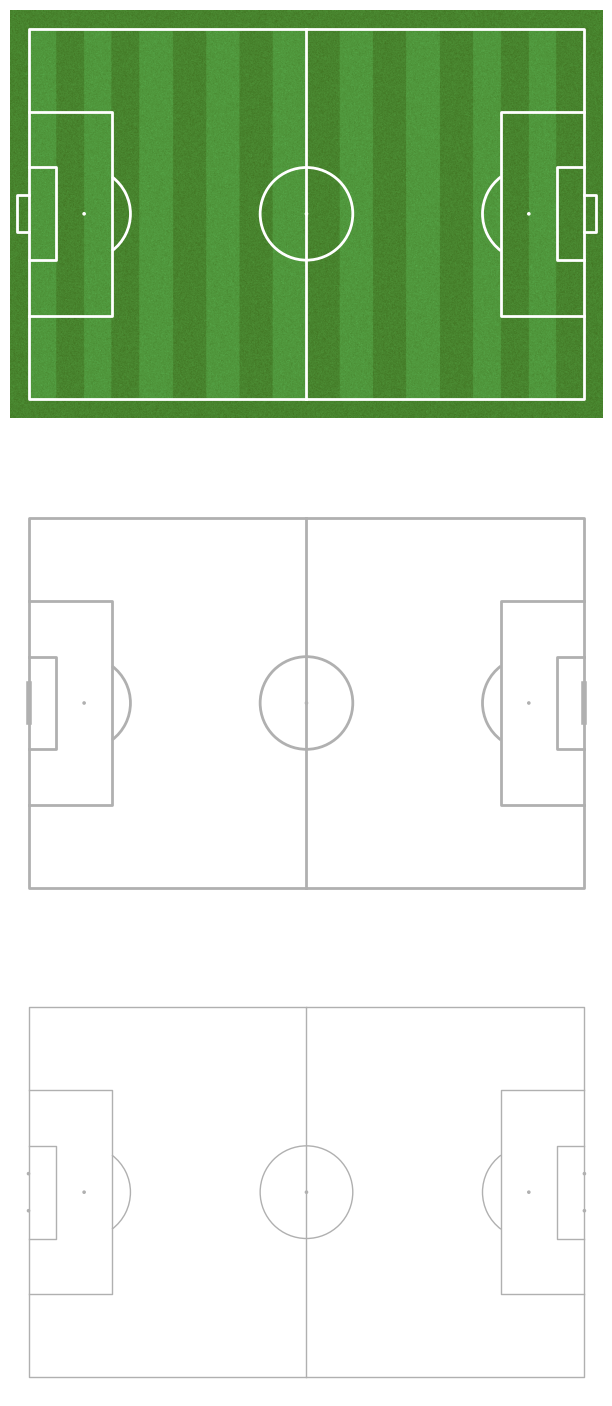

In [228]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 18))
pitch = Pitch(pitch_color='grass', line_color='white',
              stripe=True,goal_type='box', goal_alpha=1)  # you can also adjust the transparency (alpha)
pitch.draw(axs[0])
pitch = Pitch(goal_type='line')
pitch.draw(axs[1])
pitch = Pitch(goal_type='circle', linewidth=1)
pitch.draw(axs[2])